In [1]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

In [2]:
from scipy.stats import norm
import torch
import MI
import marginal as mg
import bvcopula
from vine import CVine
import pickle as pkl
from train import conf
import select_copula
import utils

import matplotlib.pyplot as plt
import numpy as np


In [3]:
NSamp=10000
device = torch.device('cuda:1')
x = torch.linspace(0.,1.,NSamp).numpy()
train_x = torch.tensor(x).float().to(device=device)
Nvar = 10
rhos = np.linspace(0.,1.,NSamp)

def cov(rho):
    return np.identity(Nvar)*(1-rho)+np.ones((Nvar,Nvar))*rho
# data = np.array([mvn.rvs(np.zeros(Nvar),cov(rho),1) for rho in rhos]).squeeze()
# data.shape

In [4]:
# def det(rho,n):
#     return ((n-1)*rho + 1)*(1-rho)**(n-1)
# def entropy(rho,n):
#     return -0.5*np.log(np.abs(det(rho,n)))
lin_gauss = bvcopula.MixtureCopula(torch.linspace(-.1,.9,NSamp,device=device).unsqueeze(0),
                    torch.ones(1,NSamp,device=device),
                    [bvcopula.GaussianCopula_Likelihood().copula])

In [5]:
copula_layers = [[lin_gauss for j in range(Nvar-1-i)] for i in range(Nvar-1)]
vine = CVine(copula_layers,train_x,device=device)
# subvine = vine.create_subvine(torch.arange(0,NSamp,5))
# %time CopulaGP = subvine.stimMI(s_mc_size=1000, r_mc_size=10, sem_tol=0.01)

# CopulaGP
# vine.entropy(sem_tol=0.01, mc_size=1000, v=True).mean()

In [6]:
y=vine.sample().cpu().numpy()

In [7]:
new_y = y.copy()
new_y += np.repeat(y.prod(axis=-1).reshape(NSamp,1),Nvar,axis=-1)**(1/Nvar)
transformed_y = (np.argsort(new_y.flatten()).argsort()/new_y.size).reshape(new_y.shape)

In [74]:
MI.train_MINE(y,H=500,device=device)

array(0.693264, dtype=float32)

In [13]:
KSG = MI.BI_KSG(x.reshape((*x.shape,1)),new_y,)
KSG

(0.5838400765206273, -3.0631667254789927)

In [12]:
MI.Mixed_KSG(x,new_y)

(0.6521322196062007, -11.062998208725148)

In [ ]:
# MI.LNN_MI(x.reshape((*x.shape,1)),y,)/np.log(2)

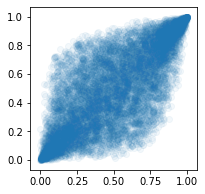

In [8]:
plt.figure(figsize=(3,3))
plt.scatter(*transformed_y[:,[0,1]].T,alpha=0.05)

In [32]:
samples = torch.tensor(transformed_y[:,[0,1]]).clamp(0.001,0.999).float().to(device)
out = '/home/nina/CopulaGP/synthetic_data/outputs'
(likelihoods, waic) = select_copula.select_copula_model(x,transformed_y[:,[0,1]],device,'benchmark',out,0,1,
                                    train_x=train_x[torch.randperm(NSamp)], train_y=samples) #[torch.randperm(NSamp)]
likelihoods

Best added copula: Clayton 180° (WAIC = -0.2334)
Best added copula: Gaussian  (WAIC = -0.2392)
Best added copula: Clayton 0° (WAIC = -0.2396)
Best added copula: Gumbel 180° (WAIC = -0.2395)
The best model is Clayton0°GaussianClayton180° with WAIC = -0.2396
Model reduced to Clayton180°
History:
Clayton180° with WAIC = -0.2334
GaussianClayton180° with WAIC = -0.2392
Clayton180° with WAIC = -0.2334


[ClaytonCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 )]

In [27]:
likelihoodTU = [bvcopula.IndependenceCopula_Likelihood(),
                bvcopula.GaussianCopula_Likelihood(),
                bvcopula.GumbelCopula_Likelihood(rotation='0°'),
                bvcopula.GumbelCopula_Likelihood(rotation='180°')] # True unconditional
likelihoodC =  [bvcopula.GaussianCopula_Likelihood(),
                bvcopula.GumbelCopula_Likelihood(rotation='180°')]
likelihoodU =  [bvcopula.GaussianCopula_Likelihood(),
                bvcopula.GumbelCopula_Likelihood(rotation='0°'),
                bvcopula.GumbelCopula_Likelihood(rotation='180°')] #0.5096


samples = torch.tensor(transformed_y[:,[0,1]]).clamp(0.001,0.999).float().to(device)
waic, model = bvcopula.infer(likelihoodC,train_x,samples,device=device) #[torch.randperm(NSamp)]
waic

tensor(-0.5610, device='cuda:1')

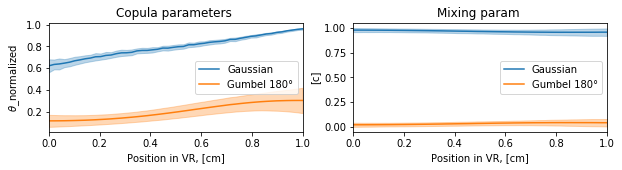

In [28]:
fig, ax = plt.subplots(1,2,figsize=(10,2))

utils.Plot_MixModel_Param_MCMC(ax,model,torch.linspace(0,1,50,device=device),np.linspace(0,1,50),particles=200)

In [15]:
#redirect logging here
def train4entropy(x,y,likelihood,shuffle=False):
    Nvar = y.shape[-1]
    data_layers = [torch.tensor(y).clamp(0.001,0.999).float().to(device)]
    copula_layers, model_layers = [], []
    for m in range(0,Nvar-1):
        copulas, layer, models = [], [], []
        for n in range(1,Nvar-m):
            print(m,n+m)
            if shuffle:
                x = x[torch.randperm(NSamp)]
            samples = data_layers[-1][...,[n,0]]
            waic, model = bvcopula.infer(likelihood,x,samples,device=device) 
            print(f'WAIC: {waic}')
            if shuffle:
                x = x[torch.randperm(NSamp)]
            with torch.no_grad():
                f = model(x).mean
                copula = model.likelihood.get_copula(f)
                copulas.append(copula)
                layer.append(copula.ccdf(samples))
                models.append(model)
        data_layers.append(torch.stack(layer,dim=-1))
        copula_layers.append(copulas)
        model_layers.append(models)
    print('Trained')
    vine_trained = CVine(copula_layers,x,device=device)
    entropies = vine_trained.entropy(sem_tol=0.01, mc_size=3000, v=True)
    return model_layers, vine_trained, entropies
likelihoodC = [bvcopula.GaussianCopula_Likelihood(),
              bvcopula.GumbelCopula_Likelihood(rotation='0°'),
                bvcopula.GumbelCopula_Likelihood(rotation='180°')]
likelihoodU = [bvcopula.IndependenceCopula_Likelihood(),
                bvcopula.GaussianCopula_Likelihood(),
                bvcopula.GumbelCopula_Likelihood(rotation='0°'),
                bvcopula.GumbelCopula_Likelihood(rotation='180°')]

In [47]:
modelsC, vineC, eC = train4entropy(train_x,transformed_y[...,[0,1]],likelihoodC, shuffle=True)
# modelsU, vineU, eU = train4entropy(train_x,transformed_y,likelihoodU,shuffle=True)

0 1
WAIC: -0.5017907023429871
Trained


tensor(0.0890, device='cuda:1')

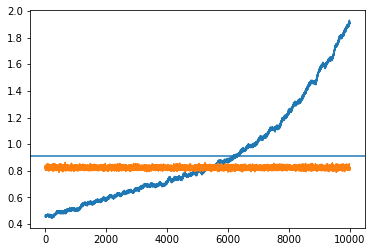

In [16]:
plt.plot(-eC.cpu().numpy())
plt.plot(-eU.cpu().numpy())
plt.axhline(-eC.mean().cpu().numpy())
(eU-eC).mean()

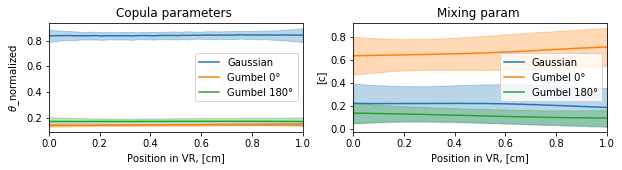

In [49]:
fig, ax = plt.subplots(1,2,figsize=(10,2))

utils.Plot_MixModel_Param_MCMC(ax,modelsC[0][0],torch.linspace(0,1,50,device=device),np.linspace(0,1,50),particles=200)

In [28]:
# data_layers = [torch.tensor(transformed_y).clamp(0.001,0.999).float().to(device)]
# copula_layers = []
# for m in range(0,Nvar-1):
# #     out_dir = f'{conf.path2outputs}/{exp_pref}/layer{m}'
#     copulas, layer = [], []
#     for n in range(1,Nvar-m):
#         print(m,n+m)
#         samples = data_layers[-1][...,[n,0]]
#         likelihood = bvcopula.MixtureCopula_Likelihood([bvcopula.IndependenceCopula_Likelihood(),
#                                                         bvcopula.GaussianCopula_Likelihood(),
#                                         bvcopula.GumbelCopula_Likelihood(rotation='180°')])
#         copula, plot_loss = fit(likelihood, samples, n_epoch=200, lr=0.02)
#         copulas.append(copula)
#         layer.append(copula.ccdf(samples.unsqueeze(-2)).squeeze())
#     data_layers.append(torch.stack(layer,dim=-1))
#     copula_layers.append(copulas)

0 1


In [8]:
results_file = f"{home}/MI_sqGaussH_dump1.pkl"
with open(results_file,'rb') as f:
    results1 = pkl.load(f)[:-1]
results_file = f"{home}/MI_sqGaussH_dump2.pkl"
with open(results_file,'rb') as f:
    results2 = pkl.load(f)
results = results1 + results2

In [9]:
# with open(results_file,'wb') as f:
#     pkl.dump(results0,f)

In [10]:
results[0][2]

[[1.7369991540908813, 0],
 [0.5944793345710434, 0.5854079795048068],
 [0.6506400740826891, 0.6217746436305439],
 [0.7280912181587887,
  0.840709671518702,
  0.8925313118940327,
  0.9605511382408769]]

In [11]:
Ns = np.array([res[0][0] for res in results])
Ns

array([6, 6, 6, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5])

In [12]:
(-torch.ones(1)).sign()

tensor([-1.])

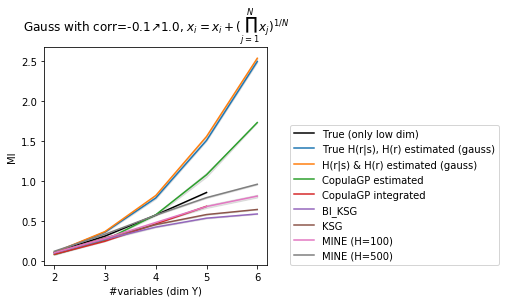

In [13]:
plt.figure(figsize=(4,4))
def line(H,label,cut=Ns.max(),color=None):
    NN = cut+1-Ns.min()
    A = np.zeros((3,NN))
    for i in range(NN):
        n = Ns.min()+i
        A[0,i] = n
        if np.any(Ns==n):
            A[1,i] = H[Ns==n].mean()
            A[2,i] = H[Ns==n].std()
    plt.plot(A[0][A[1]!=0],A[1][A[1]!=0],label=label,color=color)
    plt.fill_between(A[0][A[1]!=0],(A[1]-A[2])[A[1]!=0],(A[1]+A[2])[A[1]!=0],color='grey',alpha=0.2)
line(np.array([res[1][0] for res in results]),"True (only low dim)",cut=5,color='black')
for i,label in enumerate(["True H(r|s), H(r) estimated (gauss)","H(r|s) & H(r) estimated (gauss)"]):
    line(np.array([res[1][i+1] for res in results]),label)
for i,label in enumerate(["CopulaGP estimated","CopulaGP integrated"]):
    line(np.array([res[2][0][i] for res in results]),label)
for i,label in enumerate(["BI_KSG","KSG"]):
    line(np.array([res[2][i+1][0] for res in results]),label)
line(np.array([res[2][3][1] for res in results]),"MINE (H=100)")
line(np.array([res[2][3][-1] for res in results]),"MINE (H=500)")
# for i,H in enumerate([50,100,200,500]):
#     line(np.array([res[2][3][i] for res in results])/np.log(2),f"MINE (H={H})")
# plt.title("Gauss with corr=-0.1↗1.0, $x_i = x_i + \prod_{j=1}^{N} x_j$")
plt.title("Gauss with corr=-0.1↗1.0, $x_i = x_i + (\prod_{j=1}^{N} x_j)^{1/N}$")
plt.xlabel("#variables (dim Y)")
plt.ylabel("MI")
plt.legend(loc=(1.1,0));